In [22]:
from fbprophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import itertools
import numpy as np
import pandas as pd
import os
from xgboost.sklearn import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook

In [5]:
# read from level file
level = pd.read_csv('../../dataset/data_xyz/provinceData/level.csv')
gdp = pd.read_csv('../../dataset/gdp_2021.csv')
population_density = pd.read_csv('../../dataset/population_density.csv')
population7th = pd.read_csv('../../dataset/population7th.csv')
aging_rate_2021 = pd.read_csv('../../dataset/aging_rate_2021.csv')
vaccinate = pd.read_csv('../../dataset/vaccinate/vaccinataion_china.csv')

In [6]:
def findAllFile(base):
    for root, ds, fs in os.walk(base):
        for f in fs:
            if f.endswith('.json'):
#                 yield f
                fullname = os.path.join(root, f)
                yield fullname,f

In [7]:
# load data from every province
province_days = []
province_names = []
base = '../../dataset/data_xyz/provinceData'
total_data = pd.DataFrame()
for i,f in findAllFile(base):
    # transform date
    data = pd.read_json(i)
    data = pd.json_normalize(data['data'])
    data['dateId'] = pd.to_datetime(data['dateId'], format='%Y%m%d')
    # transform end
    data['Province'] = f[:-5]
    break

In [8]:
data

,confirmedCount,confirmedIncr,curedCount,curedIncr,currentConfirmedCount,currentConfirmedIncr,dateId,deadCount,deadIncr,highDangerCount,midDangerCount,suspectedCount,suspectedCountIncr,Province
0,9,9,0,0,9,9,2020-01-23,0,0,0,0,0,0,山东
1,21,12,0,0,21,12,2020-01-24,0,0,0,0,0,0,山东
2,39,18,0,0,39,18,2020-01-25,0,0,0,0,0,0,山东
3,63,24,0,0,63,24,2020-01-26,0,0,0,0,0,0,山东
4,87,24,0,0,87,24,2020-01-27,0,0,0,0,0,0,山东
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
823,2733,0,2677,2,49,-2,2022-05-11,7,0,0,0,14,0,山东
824,2733,0,2679,2,47,-2,2022-05-12,7,0,0,0,14,0,山东
825,2734,1,2681,2,46,-1,2022-05-13,7,0,0,0,14,0,山东
826,2734,0,2683,2,44,-2,2022-05-14,7,0,0,0,14,0,山东


In [32]:
prophet_a=Prophet(changepoint_prior_scale=0.500,seasonality_prior_scale=0.01)
prophet_active=pd.DataFrame(zip(list(data['dateId']),list(data['currentConfirmedCount'])),columns=['ds','y'])

prophet_a.fit(prophet_active)
df_cv = cross_validation(prophet_a, initial='60 days', period='60 days', horizon = '60 days')
# df_cv.head()

future_active = prophet_a.make_future_dataframe(periods=365)
future_active.tail()

forecast_active = prophet_a.predict(future_active)
forecast_active[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 13 forecasts with cutoffs between 2020-03-26 00:00:00 and 2022-03-16 00:00:00


  0%|          | 0/13 [00:00<?, ?it/s]

,ds,yhat,yhat_lower,yhat_upper
1188,2023-05-11,519.483502,-4807.330794,5932.896774
1189,2023-05-12,518.730704,-4897.501143,5962.793664
1190,2023-05-13,519.833491,-4867.837496,5893.167003
1191,2023-05-14,520.432635,-4873.640638,5935.429580
1192,2023-05-15,521.690624,-4852.704999,6026.292777


In [28]:
prophet_active_forecast=forecast_active.copy()
active_cases_forecast=prophet_a.predict(future_active)

<IPython.core.display.Javascript object>


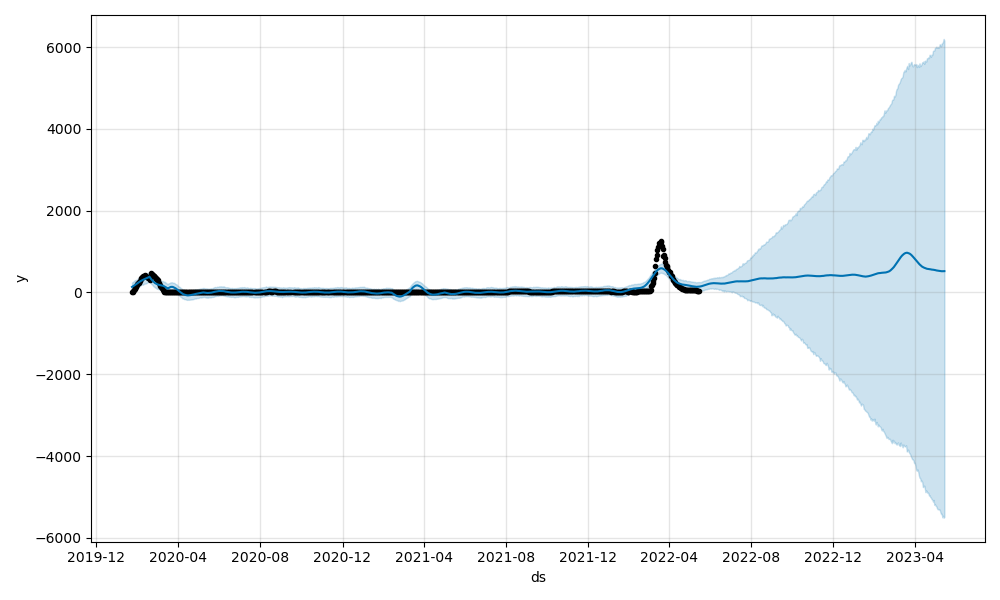

Figure(1000x600)


In [29]:
print(prophet_a.plot(active_cases_forecast))

<IPython.core.display.Javascript object>


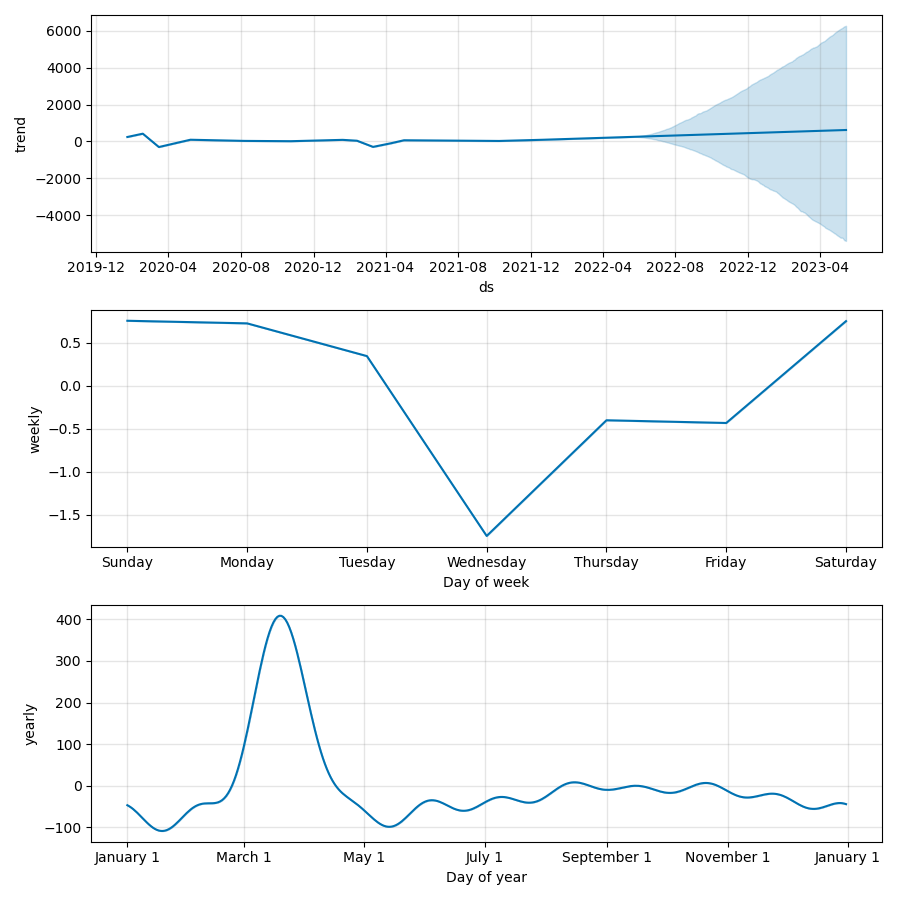

Figure(900x900)


In [30]:
print(prophet_a.plot_components(active_cases_forecast))

In [23]:
# param_grid = {  
#     'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#     'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
# }

# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# rmses = []  # Store the RMSEs for each params here
# cutoffs = pd.to_datetime(['2020-03-15', '2020-06-15', '2020-09-15','2020-12-15', '2021-03-15', '2021-06-15', '2021-09-15','2021-12-15','2022-03-15'])
# # Use cross validation to evaluate all parameters
# for params in all_params:
#     m = Prophet(**params).fit(prophet_active)  # Fit model with given params
#     df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
#     df_p = performance_metrics(df_cv, rolling_window=1)
#     rmses.append(df_p['rmse'].values[0])

# # Find the best parameters
# tuning_results = pd.DataFrame(all_params)
# tuning_results['rmse'] = rmses
# print(tuning_results)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fd18b262790>
INFO:prophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fd18b29faf0>
INFO:prophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fd18b316df0>
INFO:prophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fd1676d80

    changepoint_prior_scale  seasonality_prior_scale         rmse
0                     0.001                     0.01   244.994059
1                     0.001                     0.10   269.292649
2                     0.001                     1.00   425.744961
3                     0.001                    10.00  1881.414258
4                     0.010                     0.01   240.831404
5                     0.010                     0.10   270.442741
6                     0.010                     1.00   439.094351
7                     0.010                    10.00  1942.819634
8                     0.100                     0.01   240.557030
9                     0.100                     0.10   250.260142
10                    0.100                     1.00   475.302855
11                    0.100                    10.00  1906.443177
12                    0.500                     0.01   199.580790
13                    0.500                     0.10   201.261905
14        

In [34]:
forecast_active[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2020-01-23,135.181892,29.740649,256.655067
1,2020-01-24,145.097815,29.085166,255.166362
2,2020-01-25,156.803937,40.974403,262.855832
3,2020-01-26,167.816370,59.686222,285.695580
4,2020-01-27,179.176917,66.941178,282.170914
...,...,...,...,...
1188,2023-05-11,519.483502,-4807.330794,5932.896774
1189,2023-05-12,518.730704,-4897.501143,5962.793664
1190,2023-05-13,519.833491,-4867.837496,5893.167003
1191,2023-05-14,520.432635,-4873.640638,5935.429580


In [36]:
data[['dateId','currentConfirmedCount']]

,dateId,currentConfirmedCount
0,2020-01-23,9
1,2020-01-24,21
2,2020-01-25,39
3,2020-01-26,63
4,2020-01-27,87
...,...,...
823,2022-05-11,49
824,2022-05-12,47
825,2022-05-13,46
826,2022-05-14,44


<IPython.core.display.Javascript object>


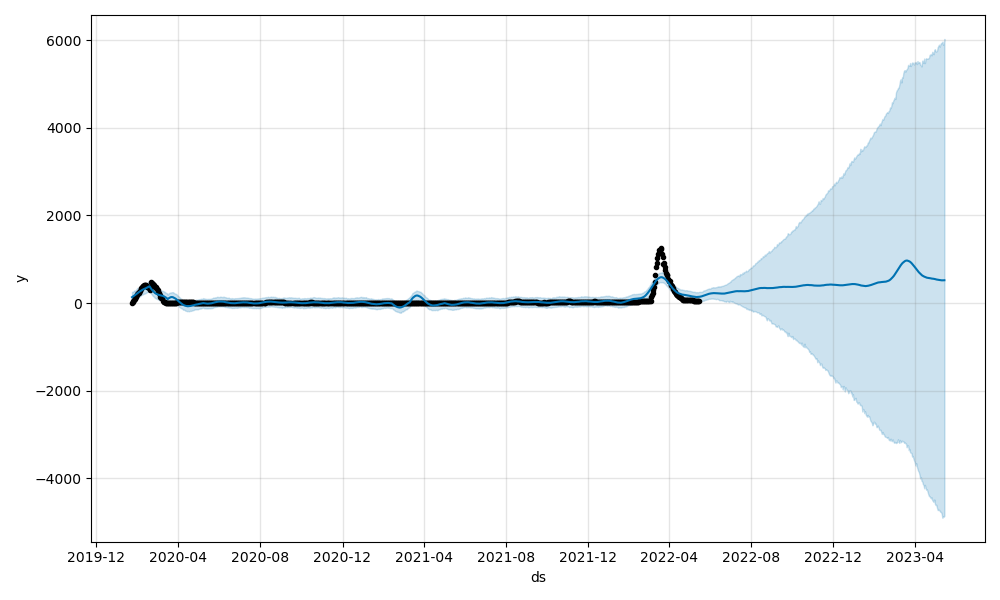

<IPython.core.display.Javascript object>


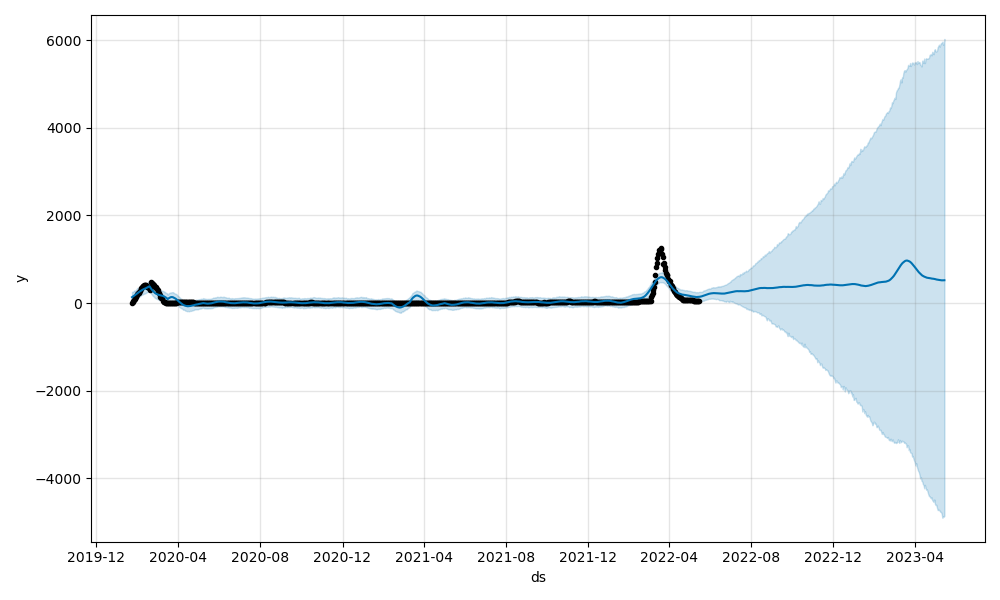

In [38]:
prophet_a.plot(forecast_active)